## Семинар 4: "Сверточные сети"

ФИО: Хапкин Артем Владимирович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

/home/temkahap/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    size = len(signal)-len(kernel)+1
    for i in range(size):
        signal_convolved[i] = np.sum([signal[i+j]*kernel[len(kernel) - 1 - j] for j in range(len(kernel))])
            
    
    return signal_convolved

In [3]:
signal = np.array([1,1,1,1,1,1])
kernel = np.array([1,2])
type(t_convolve(signal, kernel))



numpy.ndarray

Проверим правильность реализации, сравнив с реализацией из scipy

In [4]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

a = np.testing.assert_allclose(t_result, b_result)
print (t_result == b_result)
#Вроде все правильно

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Посмотрим как операция свертки может помочь нам убрать шум из сигнала

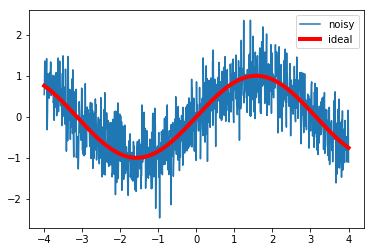

In [5]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)


Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [6]:
np.array([0.2 for i in range(5)])

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

In [7]:
k = 5
denoised_signal = t_convolve(signal, np.array([ 1/5 for i in range(k)])) ### YOUR CODE HERE #####
denoised_signal.shape
x[2:-2].shape

(996,)

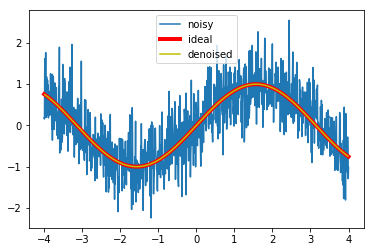

In [8]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [9]:
### YOUR CODE HERE #####

g = lambda x: (sum([(x[i] - np.sin(x[i])) **2 for i in range(len(x))]))**(0.5)/len(x)  
flag = []
t = 0
for i in range(5, 200):
    t+=1
    x = t_convolve(noisy_signal, np.array([1/i for j in range(i)]))
    flag.append(g(x))
print (np.array(flag).argmin())


194


#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [10]:
def convert(img, coefs=np.array([0.299, 0.587, 0.114])):
    return np.dot(img[..., :3], coefs)


<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

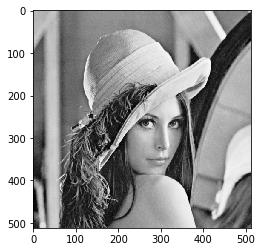

In [11]:
image = plt.imread('Lenna.png')
plt.imshow(image)
plt.imshow(convert(image), cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [12]:
from skimage.color import rgb2gray
def sobel(img):
    
    sobel_kernel_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobel_kernel_v = np.transpose(sobel_kernel_h)
    conv_x = convolve(img,sobel_kernel_h)
    conv_y = convolve(img,sobel_kernel_v)
    edge = np.sqrt(conv_x**2 + conv_y**2)

    return edge

Получим градиентную Лену.

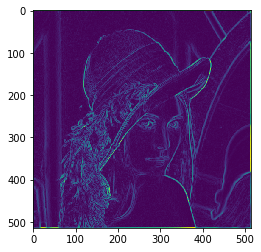

In [14]:
plt.imshow(sobel(rgb2gray(image)))


В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [15]:


def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim+1
    ##### YOUR CODE HERE #####
    out = np.zeros((signal.shape[0],signal.shape[1], signal.ndim+1))
    out[...,0] = convolve(kernel[0].reshape(1,1,-1), signal, mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,1] = convolve(signal, kernel[1].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,2] = convolve(signal, kernel[2].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    out[...,3] = convolve(signal, kernel[3].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0]-2,bw_image.shape[1]-2)
    return out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

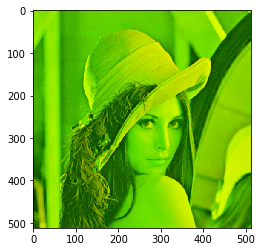

In [17]:
##### YOUR CODE HERE #####
bank_filter = np.array(
      [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 1]])

bw_image = sobel(rgb2gray(image))
bgr = t_convolve_bank(image, bank_filter)
plt.imshow(bgr[...,[1,3,2]])


<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

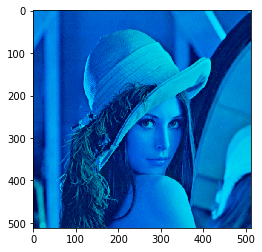

In [18]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

plt.imshow(bgr[...,[2,1,3]])


В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [19]:
import copy
import random
from scipy.ndimage.filters import maximum_filter, median_filter, gaussian_filter

def maxpool(img, window_size):
    assert(img.ndim == 3)
    temp = copy.deepcopy(img)
    for i in range(0,img.ndim):
        a=temp[...,i]
        wind = np.ones((window_size,window_size))
        temp[...,i] = a*(a == maximum_filter(a,footprint=wind))
    return temp

def medianpool(img,window_size):
    assert(img.ndim == 3)
    ##### YOUR CODE HERE #####
    temp = copy.deepcopy(img)
    for i in range(0,img.ndim):
        a=temp[...,i]
        wind = np.ones((window_size,window_size))
        temp[...,i] = a*(a == median_filter(a,footprint=wind))
    return temp

In [20]:
def salt_and_pepper(image):
    row,col,ch= image.shape
    return image + np.random.normal(1,0.09,(row,col,ch)).reshape(row,col,ch)



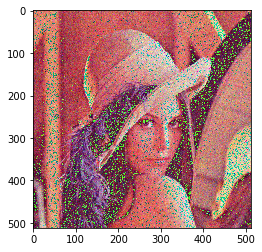

In [21]:
image = plt.imread('Lenna.png')
zzz = salt_and_pepper(image)
plt.imshow(zzz)

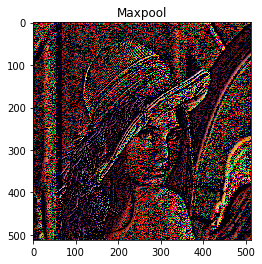

In [22]:
plt.imshow(maxpool(image,2))
plt.title('Maxpool')

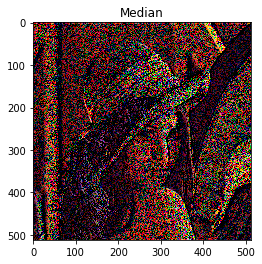

In [24]:
plt.imshow(medianpool(image,2))
plt.title('Median')

Вроде медианный справляется лучше.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [25]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)
(32, 784)


IndexError: index 16 is out of bounds for axis 0 with size 16

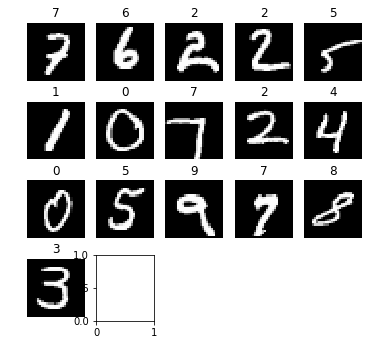

In [93]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    #print (X.shape)
    pass

for X, y in test_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    print (X.shape)
    pass

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    if (i == 1):
        print (X[i].shape)
    plt.axis('off')



In [ ]:
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2), 
                                         nn.Conv2d(8, 16, 3), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(11 * 11 * 16, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x




<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

# Архитектура 1.

In [ ]:
from tqdm import tqdm
network1 = myConvNet()
loss_fn1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(network1.parameters(), lr=0.001)

In [164]:
flag_final = []

for epoch in tqdm(range(10)):
    tl = -1
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
    
        output = network1.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        tl = max(tl, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network1.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))
    

 10%|█         | 1/10 [00:15<02:18, 15.37s/it]

Error is  0.105793072833
Accuracy score is 0.9854


 20%|██        | 2/10 [00:31<02:07, 16.00s/it]

Error is  0.234280355848
Accuracy score is 0.9871


 30%|███       | 3/10 [00:48<01:52, 16.12s/it]

Error is  0.181792162224
Accuracy score is 0.9871


 40%|████      | 4/10 [01:05<01:37, 16.30s/it]

Error is  0.212236168252
Accuracy score is 0.9865


 50%|█████     | 5/10 [01:22<01:22, 16.55s/it]

Error is  0.150494066325
Accuracy score is 0.9863


 60%|██████    | 6/10 [01:40<01:07, 16.78s/it]

Error is  0.309732943074
Accuracy score is 0.9856


 70%|███████   | 7/10 [01:58<00:50, 17.00s/it]

Error is  0.352103937494
Accuracy score is 0.986


 80%|████████  | 8/10 [02:16<00:34, 17.08s/it]

Error is  0.271934375272
Accuracy score is 0.9861


 90%|█████████ | 9/10 [02:34<00:17, 17.16s/it]

Error is  0.204000652555
Accuracy score is 0.986


100%|██████████| 10/10 [02:52<00:00, 17.27s/it]

Error is  0.207255526592
Accuracy score is 0.9864


[0.10579307283250962,
 0.23428035584799944,
 0.18179216222408531,
 0.21223616825238617,
 0.15049406632532675,
 0.30973294307431859,
 0.35210393749376961,
 0.27193437527213343,
 0.2040006525554251,
 0.20725552659183041]

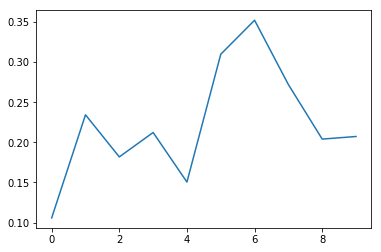

In [165]:
plt.figure()
plt.plot(flag_final)
flag_final

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [151]:
##### YOUR CODE HERE #####

predicted_losses = np.zeros(len(train_dataset))
predicted_cls = np.zeros(len(train_dataset))

for i in tqdm(range(len(train_dataset))):
        #print (i)
        X, y = train_dataset[i]
        output = network1.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        #print (X.numpy().shape)
        #print (np.array([X.numpy()]))
        #break
        loss = loss_fn1(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()
        

100%|██████████| 60000/60000 [00:28<00:00, 2117.97it/s]


In [152]:
predicted_args = predicted_losses.argsort()[-35:]
predicted_cls = predicted_cls[predicted_args]

In [155]:
predicted_cls

array([ 3.,  4.,  4.,  4.,  4.,  3.,  9.,  9.,  7.,  4.,  5.,  1.,  9.,
        2.,  7.,  4.,  3.,  2.,  0.,  9.,  7.,  4.,  7.,  2.,  7.,  7.,
        2.,  5.,  2.,  6.,  2.,  5.,  1.,  7.,  8.])

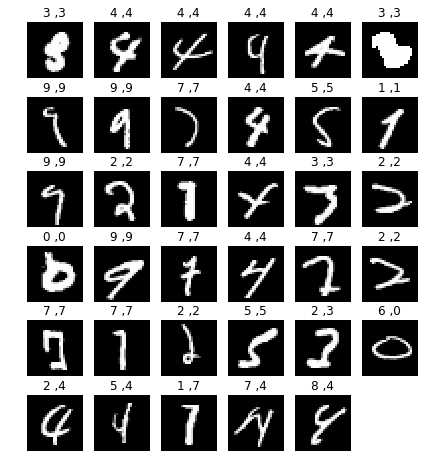

In [157]:
plt.figure(figsize=(7, 8))
for i in range(len(predicted_args)):
    plt.subplot(6, 6, i+1)
    plt.imshow(train_dataset[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    
    plt.title(str(int(predicted_cls[i])) + ' ,' + str(train_dataset[predicted_args[i]][1])  )
    plt.axis('off')
    

# Архитектура 2

In [166]:
class myConvNet2(nn.Module):
    def __init__(self):
        super(myConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3), nn.ReLU(),
                                        nn.MaxPool2d(2), nn.Conv2d(16, 32, 3))
        self.linear_layers = nn.Sequential(nn.Linear(32 * 10 * 10, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



In [167]:
network2 = myConvNet()
loss_fn2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(network2.parameters(), lr=0.001)

In [168]:
flag_final = []

for epoch in tqdm(range(10)):
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
        flag = []
    
        output = network2.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        tl = max(-1, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network2.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))
    

 10%|█         | 1/10 [00:15<02:16, 15.17s/it]

Error is  0.0232395026833
Accuracy score is 0.9837


 20%|██        | 2/10 [00:30<02:01, 15.23s/it]

Error is  0.00124418002088
Accuracy score is 0.9822


 30%|███       | 3/10 [00:46<01:47, 15.40s/it]

Error is  0.00124094844796
Accuracy score is 0.9853


 40%|████      | 4/10 [01:01<01:32, 15.37s/it]

Error is  0.169749066234
Accuracy score is 0.9858


 50%|█████     | 5/10 [01:16<01:16, 15.27s/it]

Error is  0.00514993956313
Accuracy score is 0.9877


 60%|██████    | 6/10 [01:32<01:01, 15.36s/it]

Error is  0.000124492828036
Accuracy score is 0.9855


 70%|███████   | 7/10 [01:47<00:46, 15.41s/it]

Error is  0.00942749436945
Accuracy score is 0.9873


 80%|████████  | 8/10 [02:03<00:30, 15.47s/it]

Error is  0.0497917793691
Accuracy score is 0.9872


 90%|█████████ | 9/10 [02:19<00:15, 15.48s/it]

Error is  0.00245686434209
Accuracy score is 0.9823


100%|██████████| 10/10 [02:34<00:00, 15.42s/it]

Error is  8.62410233822e-05
Accuracy score is 0.9867


[0.023239502683281898,
 0.0012441800208762288,
 0.0012409484479576349,
 0.16974906623363495,
 0.0051499395631253719,
 0.00012449282803572714,
 0.0094274943694472313,
 0.049791779369115829,
 0.0024568643420934677,
 8.6241023382171988e-05]

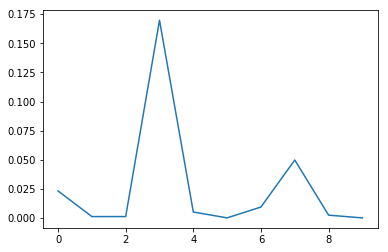

In [169]:
plt.figure()
plt.plot(flag_final)
flag_final

In [170]:
##### YOUR CODE HERE #####

predicted_losses = np.zeros(len(train_dataset))
predicted_cls = np.zeros(len(train_dataset))

for i in tqdm(range(len(train_dataset))):
        #print (i)
        X, y = train_dataset[i]
        output = network1.forward(Variable(torch.from_numpy(np.array([X.numpy()]))))
        #print (X.numpy().shape)
        #print (np.array([X.numpy()]))
        #break
        loss = loss_fn1(output, Variable(torch.from_numpy(np.array([y])), requires_grad=False))
        predicted_losses[i] = loss.data[0]
        predicted_cls[i] = output.data.numpy().argmax()
        

100%|██████████| 60000/60000 [00:31<00:00, 1921.26it/s]


In [171]:
predicted_args = predicted_losses.argsort()[-35:]
predicted_cls = predicted_cls[predicted_args]

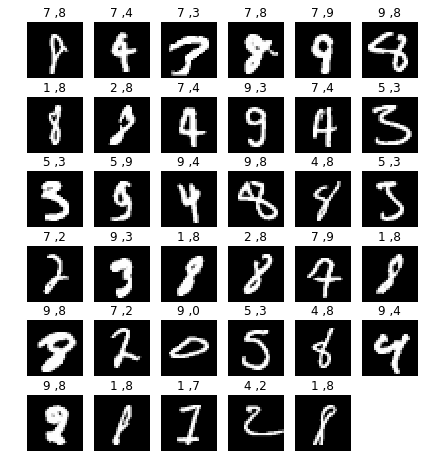

In [172]:
plt.figure(figsize=(7, 8))
for i in range(len(predicted_args)):
    plt.subplot(6, 6, i+1)
    plt.imshow(train_dataset[predicted_args[i]][0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    
    plt.title(str(int(predicted_cls[i])) + ' ,' + str(train_dataset[predicted_args[i]][1])  )
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [173]:
##### YOUR CODE HERE #####

#Попробуем добавить количество каналов в самые первые сверточные слои, мб поможет
class myConvNet3(nn.Module):
    def __init__(self):
        super(myConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 12, 3), nn.ReLU(), 
                                         nn.Conv2d(12, 16, 3), nn.ReLU(),
                                        nn.MaxPool2d(2), nn.Conv2d(16, 32, 3))
        self.linear_layers = nn.Sequential(nn.Linear(32 * 10 * 10, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [174]:
network3 = myConvNet()
loss_fn3 = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(network3.parameters(), lr=0.001)

In [175]:
flag_final = []

for epoch in tqdm(range(10)):
    flag = []

    for X, y in train_loader:
        #print ("shape = ", X.shape)
        flag = []
    
        output = network3.forward(Variable(X))
        
        loss = loss_fn1(output, Variable(y, requires_grad=False))

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        
        tl = max(-1, loss.data[0])
        flag.append(tl)
    

    pred = np.array([])
    real = np.array([])



    for X, y in test_loader:
        output = network3.forward(Variable(X))
        
        pred = np.append(pred, output.data.numpy().argmax(axis = 1))
        real = np.append(real, y.numpy())


    flag_final.append(np.array(flag).mean())
    print ("Error is ", np.array(flag).mean())
    print ("Accuracy score is", accuracy_score(pred, real))

 10%|█         | 1/10 [00:16<02:24, 16.02s/it]

Error is  0.00524167623371
Accuracy score is 0.9796


 20%|██        | 2/10 [00:31<02:07, 15.94s/it]

Error is  0.0843428224325
Accuracy score is 0.9868


 30%|███       | 3/10 [00:45<01:45, 15.05s/it]

Error is  0.186017557979
Accuracy score is 0.9854


 40%|████      | 4/10 [00:58<01:27, 14.56s/it]

Error is  0.0249439924955
Accuracy score is 0.9884


 50%|█████     | 5/10 [01:13<01:13, 14.69s/it]

Error is  0.238523453474
Accuracy score is 0.9879


 60%|██████    | 6/10 [01:29<00:59, 14.85s/it]

Error is  0.000133021385409
Accuracy score is 0.9882


 70%|███████   | 7/10 [01:45<00:45, 15.04s/it]

Error is  0.00322322128341
Accuracy score is 0.9898


 80%|████████  | 8/10 [02:00<00:30, 15.08s/it]

Error is  0.00187546841335
Accuracy score is 0.988


 90%|█████████ | 9/10 [02:15<00:15, 15.02s/it]

Error is  0.123461775482
Accuracy score is 0.989


100%|██████████| 10/10 [02:30<00:00, 15.07s/it]

Error is  0.000988717074506
Accuracy score is 0.9874


[0.0052416762337088585,
 0.084342822432518005,
 0.18601755797863007,
 0.024943992495536804,
 0.2385234534740448,
 0.00013302138540893793,
 0.0032232212834060192,
 0.0018754684133455157,
 0.1234617754817009,
 0.00098871707450598478]

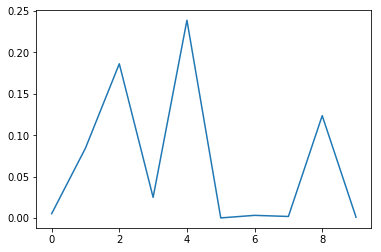

In [176]:
plt.figure()
plt.plot(flag_final)
flag_final

Ну не особо улучшилось, но значения ошибок стали чуть поменьше.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: